In [3]:
import pandas as pd
import json
import csv
import io
import requests
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
from datetime import datetime
import time
import numpy as np
from itertools import islice

In [4]:
from shapely.geometry import Polygon

In [5]:
import matplotlib.pyplot as plt

In [6]:
os.chdir('')

In [18]:
# cleaning dropbox addresses
addr1 = pd.read_csv('20220421_Dec_20_dropbox_list_geocode_results.csv')
addr1ft = addr1[(addr1['Accuracy Type'] == 'rooftop' )| (addr1['Accuracy Type'] == 'range_interpolation')].copy()

In [19]:
addr1ft.columns = addr1ft.columns.str.lower().str.replace(' ','_')

In [20]:
addr1ft = addr1ft[['adjust_address','latitude','longitude']].copy()

In [21]:
addr1ft.columns = ['address', 'lat','long']

In [22]:
addr2 = pd.read_csv('20220503_dropbox_dec_20_redo_geocodio_6ea96c2c4c51b40d37fb555e1ec00dca20e8015d.csv')

In [23]:
addr2ft = addr2[(addr2['Accuracy Type'] == 'rooftop' )| (addr2['Accuracy Type'] == 'range_interpolation')].copy()

In [24]:
addr2ft.columns = addr2ft.columns.str.lower().str.replace(' ','_')

In [25]:
addr2ft = addr2ft[['address','latitude','longitude']].copy()

In [26]:
addr2ft.columns = ['address','lat','long']

In [27]:
addr2ft.head()

,address,lat,long
0,"167 Baker Place, Newton, GA 39870",31.317829,-84.342261
1,"1300 Joe Frank Harris Pkwy. Cartersville, GA 3...",34.206186,-84.813805
2,"2525 Pio Nono Ave., Macon, GA 31206",32.810040,-83.664496
3,"66 Captain Matthew Freeman Drive, Richmond Hil...",31.852872,-81.262760
4,"151 S College St, Pembroke, GA 31321",32.131071,-81.622011


In [28]:
addr3 = pd.read_excel('20220503_dropbox_dec_20_arc_results_TableToExcel.xlsx')

In [29]:
addr3ft = addr3[['address','X','Y']][addr3.X != 0].copy()

In [30]:
addr3ft.columns = ['address', 'long','lat']

In [31]:
# three outliers, hand geocoding.
addr4 = pd.read_csv('two_dropbox_geocodio_857ff4572c44fdafe0ffeef3b8796c9931501693.csv')

In [32]:
addr4ft = addr4[['address','Latitude','Longitude']].copy()
addr4ft.columns = ['address','lat','long']

In [33]:
dec20 = pd.concat([addr1ft, addr2ft, addr3ft, addr4ft])

load 2022 dropboxes

generating isochrones<br>
time ticks - 10mins/600s, 20mins/1200s, 30mins/1800s

In [35]:
allboxes = pd.read_csv('20220505_dropboxes_unified.csv')

In [37]:
allboxes = allboxes.drop('Unnamed: 0', axis = 1)
allboxes = allboxes.reset_index()

In [38]:
allboxes.head()

,index,address_x,lat,long,in_2022,Unnamed: 0.1,address_y,in_2020
0,0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,2.0,"46 Old School Rd. Georgetown, GA 39854",True
1,1,"664 Austin Avenue East, Pearson, GA 31642",31.293249,-82.842304,True,NaN,NaN,NaN
2,2,"201 Freeman Street, Suite 10, Claxton, GA 30417",32.162091,-81.907730,True,NaN,NaN,NaN
3,3,"676 West Main, Gibson, GA 30810",33.231311,-82.607464,True,NaN,NaN,NaN
4,4,"12560 Augusta Hwy, Sparta, GA 31087",33.279545,-82.964652,True,NaN,NaN,NaN


In [62]:
allboxes[(allboxes.address_x.str.contains('atlanta',case = False)) & (pd.isna(allboxes.address_x) == False)]

,index,address_x,lat,long,in_2022,Unnamed: 0.1,address_y,in_2020
74,74,"2235 Briarwood Way NE, Atlanta, GA 30329",33.849178,-84.329885,True,NaN,NaN,NaN
95,95,"269 Buckhead Avenue, NE, Atlanta, GA 30305",33.837803,-84.379061,True,111.0,"Buckhead Library 269 Buckhead Avenue, NE, Atla...",True
96,96,"3201 Martin Luther King Jr. Drive, Atlanta, GA...",33.754142,-84.491799,True,NaN,NaN,NaN
100,100,"3100 Enon Road, SW, Atlanta, GA 30331",33.667838,-84.578194,True,NaN,NaN,NaN
116,116,"40 Atlanta St, McDonough GA 30253",33.448807,-84.148319,True,174.0,"40 Atlanta Street McDonough, GA 3025340",True


In [44]:
def get_isochrone(index,lat,long):
    # three different time ticks
    df = gpd.GeoDataFrame()
    for travel_time in [600,1200,1800]:
        headers = {
            'Accept': 'application/geo+json',
            'X-Application-Id': '',
            'X-Api-Key': '',
        }

        json_data = {
            'arrival_searches': [
                {
                    'id': str(index),
                    'coords': {
                        'lat': lat, 
                        'lng': long,
                    },
                    'transportation': {
                        'type': 'public_transport',
                    },
                    'arrival_time': '2022-05-05T18:01:00.000Z',
                    'travel_time': travel_time,
                },
            ],
        }

        response = requests.post('https://api.traveltimeapp.com/v4/time-map', headers=headers, json=json_data)
        geojson = json.dumps(response.json())
        polygon = gpd.read_file(geojson)
        polygon['travel_time'] = travel_time
        polygon['index'] = index
        df = df.append(polygon)
    return (df)

In [41]:
masterdf = gpd.GeoDataFrame()

In [74]:
for (i,r) in allboxes[].iterrows():
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

0
1
2
3
error
4
error
5
error
6
error
7
error
8
error
9
error
10
error
11
error
12
error
13
error
14


KeyboardInterrupt: 

In [87]:
for i in list(np.arange(4,365)):
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

error
4
error
5


KeyboardInterrupt: 

In [95]:
for i in list(np.arange(5,365)):
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
#         time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
#         print(index)
#         print(lat)
#         print(long)
    except Exception:
        print('error')
        print (i)

5
6
7
8
error
9
error
10
error
11
error
12
error
13
error
14
error
15
error
16
error
17
error
18
error
19
error
20
error
21


KeyboardInterrupt: 

In [100]:
for i in list(np.arange(9,365)):
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
#         print(index)
#         print(lat)
#         print(long)
    except Exception:
        print('error')
        print (i)

9
10
11
error
12
13
14
15
16
17
18
error
19
error
20
error
21
error
22
error
23
error
24
error
25
error
26
error
27
error
28


KeyboardInterrupt: 

In [101]:
for i in list(np.arange(19,365)):
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(2)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

error
19
error
20
21
22
23
24
error
25
error
26
error
27
error
28
error
29
error
30
error
31
error
32
error
33
error
34
error
35
error
36
error
37
error
38
error
39
error
40
error
41
error
42
error
43
error
44
error
45
error
46
error
47
error
48
error
49
error
50
error
51
error
52
error
53
error
54
error
55
error
56
error
57
error
58
error
59
error
60
error
61
error
62
error
63
error
64
error
65
error
66
error
67
error
68
error
69
error
70
error
71
error
72
error
73
error
74
error
75
error
76
error
77
error
78
error
79
error
80
error
81


KeyboardInterrupt: 

In [102]:
for i in list(np.arange(25,365)):
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(5)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

25
26
27
28
error
29
error
30
error
31


KeyboardInterrupt: 

In [103]:
for i in list(np.arange(29,365)):
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

29
30
31
32
error
33
error
34
error
35
error
36
error
37


KeyboardInterrupt: 

In [178]:
input1 = list(np.arange(183,365))

In [179]:
len(input1)

182

In [189]:
newlist = []

In [190]:
for i in range(0,182,10):
    x=i
    newlist.append(input1[x:x+10])

In [191]:
newlist

[[183, 184, 185, 186, 187, 188, 189, 190, 191, 192],
 [193, 194, 195, 196, 197, 198, 199, 200, 201, 202],
 [203, 204, 205, 206, 207, 208, 209, 210, 211, 212],
 [213, 214, 215, 216, 217, 218, 219, 220, 221, 222],
 [223, 224, 225, 226, 227, 228, 229, 230, 231, 232],
 [233, 234, 235, 236, 237, 238, 239, 240, 241, 242],
 [243, 244, 245, 246, 247, 248, 249, 250, 251, 252],
 [253, 254, 255, 256, 257, 258, 259, 260, 261, 262],
 [263, 264, 265, 266, 267, 268, 269, 270, 271, 272],
 [273, 274, 275, 276, 277, 278, 279, 280, 281, 282],
 [283, 284, 285, 286, 287, 288, 289, 290, 291, 292],
 [293, 294, 295, 296, 297, 298, 299, 300, 301, 302],
 [303, 304, 305, 306, 307, 308, 309, 310, 311, 312],
 [313, 314, 315, 316, 317, 318, 319, 320, 321, 322],
 [323, 324, 325, 326, 327, 328, 329, 330, 331, 332],
 [333, 334, 335, 336, 337, 338, 339, 340, 341, 342],
 [343, 344, 345, 346, 347, 348, 349, 350, 351, 352],
 [353, 354, 355, 356, 357, 358, 359, 360, 361, 362],
 [363, 364]]

In [122]:
for listi in newlist:
    for i in listi:
        try:
            index = allboxes['index'].iloc[i]
            lat = allboxes['lat'].iloc[i]
            long = allboxes['long'].iloc[i]
            result = get_isochrone(index, lat, long)
            time.sleep(1)
            masterdf = masterdf.append(result)
            print (i)
        except Exception:
            print('error')
            print (i)
        time.sleep(10)

33
34
35
36
error
37
error
38
error
39
error
40
error
41


KeyboardInterrupt: 

In [125]:
for listi in newlist[2:]:
    for i in listi:
        try:
            index = allboxes['index'].iloc[i]
            lat = allboxes['lat'].iloc[i]
            long = allboxes['long'].iloc[i]
            result = get_isochrone(index, lat, long)
            time.sleep(1)
            masterdf = masterdf.append(result)
            print (i)
        except Exception:
            print('error')
            print (i)
    requests.session().close()

41
42
43
44
error
45
error
46
error
47
error
48
error
49
error
50
error
51
error
52


KeyboardInterrupt: 

In [126]:
for listi in newlist[3:]:
    for i in listi:
        try:
            index = allboxes['index'].iloc[i]
            lat = allboxes['lat'].iloc[i]
            long = allboxes['long'].iloc[i]
            result = get_isochrone(index, lat, long)
            time.sleep(1)
            masterdf = masterdf.append(result)
            print (i)
        except Exception:
            print('error')
            print (i)
    requests.session().close()

45
46
47
48
error
49
error
50
error
51


KeyboardInterrupt: 

In [232]:
for listi in newlist[16:17]:
    for i in listi:
        try:
            index = allboxes['index'].iloc[i]
            lat = allboxes['lat'].iloc[i]
            long = allboxes['long'].iloc[i]
            result = get_isochrone(index, lat, long)
            time.sleep(1)
            masterdf = masterdf.append(result)
            print (i)
        except Exception:
            print('error')
            print (i)

343
344
345
346
347
348
349
350
351
352


In [92]:
masterdf = masterdf.append(try4)

In [237]:
masterdf1.head()

,geometry,travel_time,index
0,"MULTIPOLYGON (((-85.10582 31.88716, -85.10635 ...",600,0
0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ...",1200,0
0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ...",1800,0
0,"MULTIPOLYGON (((-82.84968 31.29486, -82.84916 ...",600,1
0,"MULTIPOLYGON (((-82.85249 31.29397, -82.85039 ...",1200,1


In [249]:
redo = [x for x in list(np.arange(0,364)) if x not in list(masterdf1['index'].unique()) ]

In [250]:
for i in redo[:10]:
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

error
12
19
20
39
40
68
76
92
103
104


In [253]:
for i in redo[:1]:
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

error
12


In [265]:
for i in [364]:
    try:
        index = allboxes['index'].iloc[i]
        lat = allboxes['lat'].iloc[i]
        long = allboxes['long'].iloc[i]
        result = get_isochrone(index, lat, long)
        time.sleep(1)
        masterdf = masterdf.append(result)
        print (i)
    except Exception:
        print('error')
        print (i)

364


In [267]:
[x for x in list(np.arange(0,365)) if x not in list(masterdf1['index'].unique()) ]

[12]

In [266]:
masterdf1 = masterdf.drop_duplicates()

In [268]:
masterdf1.head()

,geometry,travel_time,index
0,"MULTIPOLYGON (((-85.10582 31.88716, -85.10635 ...",600,0
0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ...",1200,0
0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ...",1800,0
0,"MULTIPOLYGON (((-82.84968 31.29486, -82.84916 ...",600,1
0,"MULTIPOLYGON (((-82.85249 31.29397, -82.85039 ...",1200,1


In [271]:
allboxes1 = pd.merge(allboxes, masterdf1, on = 'index', how = 'outer')

In [272]:
allboxes1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1093 entries, 0 to 1092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         1093 non-null   int64   
 1   address_x     550 non-null    object  
 2   lat           1093 non-null   float64 
 3   long          1093 non-null   float64 
 4   in_2022       550 non-null    object  
 5   Unnamed: 0.1  771 non-null    float64 
 6   address_y     771 non-null    object  
 7   in_2020       771 non-null    object  
 8   geometry      1092 non-null   geometry
 9   travel_time   1092 non-null   float64 
dtypes: float64(4), geometry(1), int64(1), object(4)
memory usage: 93.9+ KB


In [275]:
(len(allboxes)-1)*3 +1

1093

In [276]:
allboxes1.head()

,index,address_x,lat,long,in_2022,Unnamed: 0.1,address_y,in_2020,geometry,travel_time
0,0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,2.0,"46 Old School Rd. Georgetown, GA 39854",True,"MULTIPOLYGON (((-85.10582 31.88716, -85.10635 ...",600.0
1,0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,2.0,"46 Old School Rd. Georgetown, GA 39854",True,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ...",1200.0
2,0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,2.0,"46 Old School Rd. Georgetown, GA 39854",True,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ...",1800.0
3,1,"664 Austin Avenue East, Pearson, GA 31642",31.293249,-82.842304,True,NaN,NaN,NaN,"MULTIPOLYGON (((-82.84968 31.29486, -82.84916 ...",600.0
4,1,"664 Austin Avenue East, Pearson, GA 31642",31.293249,-82.842304,True,NaN,NaN,NaN,"MULTIPOLYGON (((-82.85249 31.29397, -82.85039 ...",1200.0


In [282]:
allboxes2 = gpd.GeoDataFrame(allboxes1)

generating isochrones using the updated list

In [4]:
allboxes1 = pd.read_csv('20220505_traveltime_transit_polygons_with_latlong.csv')

In [8]:
allboxes2 = allboxes1[['lat','long']].copy().drop_duplicates()

In [10]:
allboxes2['isochrone'] = True

In [5]:
masterlist = pd.read_csv('20220506_jan_21_jan_21_may_22_unified_edited.csv')

In [19]:
allboxes2.lat = [round(x,6) for x in allboxes2.lat]
allboxes2.long = [round(x,6) for x in allboxes2.long]

In [20]:
masterlist.lat = [round(x,6) for x in masterlist.lat]
masterlist.long = [round(x,6) for x in masterlist.long]

In [21]:
merge = pd.merge(masterlist, allboxes2, on = ['lat','long'], how = 'left')

In [24]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 406
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             407 non-null    int64  
 1   address_may_22         193 non-null    object 
 2   lat                    407 non-null    float64
 3   long                   407 non-null    float64
 4   in_2022                193 non-null    object 
 5   address_jan_21         265 non-null    object 
 6   in_2021                266 non-null    object 
 7   nov_2020_form_address  306 non-null    object 
 8   in_nov_2020            306 non-null    object 
 9   isochrone              344 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 35.0+ KB


In [50]:
input1 = list(np.arange(345,407))

In [51]:
newlist = []

In [52]:
for i in range(0,len(input1),10):
    x=i
    newlist.append(input1[x:x+10])

In [53]:
newlist

[[345, 346, 347, 348, 349, 350, 351, 352, 353, 354],
 [355, 356, 357, 358, 359, 360, 361, 362, 363, 364],
 [365, 366, 367, 368, 369, 370, 371, 372, 373, 374],
 [375, 376, 377, 378, 379, 380, 381, 382, 383, 384],
 [385, 386, 387, 388, 389, 390, 391, 392, 393, 394],
 [395, 396, 397, 398, 399, 400, 401, 402, 403, 404],
 [405, 406]]

In [54]:
len(masterdf)

3

In [55]:
for listi in newlist:
    for i in listi:
        try:
            index = i
            lat = merge['lat'].iloc[i]
            long = merge['long'].iloc[i]
            result = get_isochrone(index, lat, long)
            time.sleep(1)
            masterdf = masterdf.append(result)
            print (i)
        except Exception:
            print('error')
            print (i)
    time.sleep(60)

345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406


In [47]:
try1 = get_isochrone(344,34.3433,-84.9039)

In [49]:
masterdf = masterdf.append(try1)

In [61]:
masterdf.head()

,geometry,travel_time,index
0,"MULTIPOLYGON (((-84.90965 34.34551, -84.90693 ...",600,344
0,"MULTIPOLYGON (((-84.91257 34.34689, -84.91257 ...",1200,344
0,"MULTIPOLYGON (((-84.91257 34.34689, -84.91257 ...",1800,344
0,"MULTIPOLYGON (((-83.63491 32.83545, -83.63384 ...",600,345
0,"MULTIPOLYGON (((-83.63679 32.84313, -83.63679 ...",1200,345


In [ ]:
# concacenate the old isochrones with the new to get complete list of isochrones

In [70]:
allboxespolygon = gpd.read_file('20220505_traveltime_transit_isochrones.geojson')

In [87]:
allboxespolygon.head()

,travel_time,index,geometry
0,600,0,"MULTIPOLYGON (((-85.10582 31.88716, -85.10635 ..."
1,1200,0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ..."
2,1800,0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ..."
3,600,1,"MULTIPOLYGON (((-82.84968 31.29486, -82.84916 ..."
4,1200,1,"MULTIPOLYGON (((-82.85249 31.29397, -82.85039 ..."


In [71]:
type(masterdf)

geopandas.geodataframe.GeoDataFrame

In [73]:
alliso = pd.concat([allboxespolygon,masterdf])

In [76]:
alliso.head()

,travel_time,index,geometry
0,600,0,"MULTIPOLYGON (((-85.10582 31.88716, -85.10635 ..."
1,1200,0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ..."
2,1800,0,"MULTIPOLYGON (((-85.10965 31.88447, -85.10912 ..."
3,600,1,"MULTIPOLYGON (((-82.84968 31.29486, -82.84916 ..."
4,1200,1,"MULTIPOLYGON (((-82.85249 31.29397, -82.85039 ..."


In [ ]:
# but these stil need to be connected to the dropboxes somehow? 

In [99]:
merge = merge.reset_index()

In [100]:
 merge1 = pd.merge(merge, masterdf, on = 'index', how = 'outer')

In [104]:
# check that every new isochrone found theri match
merge1[(pd.isna(merge1.geometry) == False) & (pd.isna(merge1.lat) == True)]
# yes they all did find their match.

,index,Unnamed: 0,address_may_22,lat,long,in_2022,address_jan_21,in_2021,nov_2020_form_address,in_nov_2020,isochrone,geometry,travel_time


In [106]:
newadds = merge1[(pd.isna(merge1.geometry) == False)].copy()

In [108]:
newadds.head()

,index,Unnamed: 0,address_may_22,lat,long,in_2022,address_jan_21,in_2021,nov_2020_form_address,in_nov_2020,isochrone,geometry,travel_time
344,344,340,NaN,34.343251,-84.903869,NaN,NaN,NaN,"163B Manning Mill Rd. Adairsville, GA 30103",True,NaN,"MULTIPOLYGON (((-84.90965 34.34551, -84.90693 ...",600.0
345,344,340,NaN,34.343251,-84.903869,NaN,NaN,NaN,"163B Manning Mill Rd. Adairsville, GA 30103",True,NaN,"MULTIPOLYGON (((-84.91257 34.34689, -84.91257 ...",1200.0
346,344,340,NaN,34.343251,-84.903869,NaN,NaN,NaN,"163B Manning Mill Rd. Adairsville, GA 30103",True,NaN,"MULTIPOLYGON (((-84.91257 34.34689, -84.91257 ...",1800.0
347,345,341,NaN,32.838267,-83.628413,NaN,NaN,NaN,"639 Mulberry St, Macon, Ga 31201",True,NaN,"MULTIPOLYGON (((-83.63491 32.83545, -83.63384 ...",600.0
348,345,341,NaN,32.838267,-83.628413,NaN,NaN,NaN,"639 Mulberry St, Macon, Ga 31201",True,NaN,"MULTIPOLYGON (((-83.63679 32.84313, -83.63679 ...",1200.0


In [109]:
# patching the old and the new together. What needs to remain unique is the lat/long/polygon pairs so separateing them. 

In [110]:
newadds1 = newadds[['lat','long','geometry','travel_time']].copy()

In [114]:
newadds1 = newadds1.rename(columns = {'travel_time':'travel_tim'})

In [90]:
oldboxes = gpd.read_file('20220505_traveltime_transit_isochrones_with_latlong.shp')

In [113]:
oldboxes1 = oldboxes[['lat','long','geometry','travel_tim']].copy()

In [166]:
# concacenate
alllatlongiso = pd.concat([newadds1, oldboxes1])

In [199]:
alllatlongiso = alllatlongiso.drop_duplicates()

In [200]:
alllatlongiso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195 entries, 344 to 1092
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lat         1195 non-null   float64 
 1   long        1195 non-null   float64 
 2   geometry    1194 non-null   geometry
 3   travel_tim  1194 non-null   float64 
dtypes: float64(3), geometry(1)
memory usage: 46.7 KB


In [150]:
# stiching it back up with masterlist to make sure every one has an isochrone

In [201]:
alllatlongiso.lat = np.round(alllatlongiso.lat,6)
alllatlongiso.long = np.round(alllatlongiso.long,6)

In [202]:
masterlist2 = pd.merge(masterlist, alllatlongiso, on = ['lat','long'], how = 'outer')

In [214]:
masterlistlatlongdedup = masterlist[['lat','long']].copy().drop_duplicates()
len(masterlistlatlongdedup)

394

In [215]:
len(masterlist)

399

In [220]:
masterlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             399 non-null    int64  
 1   address_may_22         185 non-null    object 
 2   lat                    399 non-null    float64
 3   long                   399 non-null    float64
 4   in_2022                185 non-null    object 
 5   address_jan_21         257 non-null    object 
 6   in_2021                258 non-null    object 
 7   nov_2020_form_address  300 non-null    object 
 8   in_nov_2020            300 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 28.2+ KB


In [218]:
latlongcnt = pd.DataFrame(masterlist.groupby(['lat','long'])['Unnamed: 0'].count())

In [221]:
latlongcnt[latlongcnt['Unnamed: 0']>1]

,,Unnamed: 0
lat,long,
32.594604,-83.663166,2
33.777033,-84.246190,2
33.825185,-84.577601,2
33.870489,-84.333490,2
33.953518,-84.573838,2


In [232]:
masterlist[masterlist.lat == 33.825185]

,Unnamed: 0,address_may_22,lat,long,in_2022,address_jan_21,in_2021,nov_2020_form_address,in_nov_2020
62,62,"805 Clay Rd, Mableton GA 30126",33.825185,-84.577601,True,"805 Clay St. Mableton, GA",True,"805 Clay Rd, Mableton GA 30126",True
63,63,"805 Clay Rd, Mableton GA 30126",33.825185,-84.577601,True,"805 Clay St. Mableton, GA",True,"805 Clay Street, Mableton",True


In [203]:
# all the isochrones have been matched
masterlist2[(pd.isna(masterlist2.geometry) == False) & (pd.isna(masterlist2.lat) == True)]

,Unnamed: 0,address_may_22,lat,long,in_2022,address_jan_21,in_2021,nov_2020_form_address,in_nov_2020,geometry,travel_tim


In [204]:
# all the valid lat longs have been matched
masterlist2[(pd.isna(masterlist2.geometry) == True) & (pd.isna(masterlist2.lat) == False)]

,Unnamed: 0,address_may_22,lat,long,in_2022,address_jan_21,in_2021,nov_2020_form_address,in_nov_2020,geometry,travel_tim
36,12.0,"46 Old Georgetown, GA 39854",0.0,0.0,True,NaN,NaN,NaN,NaN,None,NaN


In [205]:
masterlist2 = gpd.GeoDataFrame(masterlist2)

In [207]:
masterlist2.head()

,Unnamed: 0,address_may_22,lat,long,in_2022,address_jan_21,in_2021,nov_2020_form_address,in_nov_2020,geometry,travel_tim
0,0.0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,"46 Old School Rd. Georgetown, GA 39854",True,"46 Old School Rd. Georgetown, GA 39854",True,"POLYGON ((-85.10582 31.88716, -85.10371 31.887...",600.0
1,0.0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,"46 Old School Rd. Georgetown, GA 39854",True,"46 Old School Rd. Georgetown, GA 39854",True,"POLYGON ((-85.10965 31.88447, -85.11018 31.884...",1200.0
2,0.0,"46 Old School Rd. Georgetown, GA 39854",31.885024,-85.100646,True,"46 Old School Rd. Georgetown, GA 39854",True,"46 Old School Rd. Georgetown, GA 39854",True,"POLYGON ((-85.10965 31.88447, -85.11018 31.884...",1800.0
3,1.0,"664 Austin Avenue East, Pearson, GA 31642",31.293249,-82.842304,True,NaN,NaN,"664 Austin Avenue East, Pearson, GA 31642",True,"POLYGON ((-82.84968 31.29486, -82.85021 31.295...",600.0
4,1.0,"664 Austin Avenue East, Pearson, GA 31642",31.293249,-82.842304,True,NaN,NaN,"664 Austin Avenue East, Pearson, GA 31642",True,"POLYGON ((-82.85249 31.29397, -82.85354 31.294...",1200.0


In [233]:
# since some of the coordiantes have more than one address on file, taking the addresses out
masterlist3 = masterlist2[['in_2022','in_2021','in_nov_2020','lat','long','geometry','travel_tim']].copy().drop_duplicates()

In [3]:
# since ballots cannot cross county boundaries, overlaying the county map with the isochrone map

In [4]:
masterlist3 = gpd.read_file('20220507_transit_isochrones_with_lat_long_for_mapping.shp')

In [5]:
masterlist3.head()

,in_2022,in_2021,in_nov_202,lat,long,travel_tim,geometry
0,1,1,1,31.885024,-85.100646,600.0,"POLYGON ((-85.10582 31.88716, -85.10371 31.887..."
1,1,1,1,31.885024,-85.100646,1200.0,"POLYGON ((-85.10965 31.88447, -85.11018 31.884..."
2,1,1,1,31.885024,-85.100646,1800.0,"POLYGON ((-85.10965 31.88447, -85.11018 31.884..."
3,1,None,1,31.293249,-82.842304,600.0,"POLYGON ((-82.84968 31.29486, -82.85021 31.295..."
4,1,None,1,31.293249,-82.842304,1200.0,"POLYGON ((-82.85249 31.29397, -82.85354 31.294..."


In [7]:
boundary = gpd.read_file('cb_2018_us_county_20m/cb_2018_us_county_20m.shp')

In [8]:
GA = boundary[boundary.STATEFP == '13'].copy()

In [9]:
GA.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
44,13,081,00351607,0500000US13081,13081,Crisp,06,706189044,21457002,"POLYGON ((-83.96128 32.03059, -83.60966 32.027..."
45,13,043,00342852,0500000US13043,13043,Candler,06,629520691,15018337,"POLYGON ((-82.25453 32.35150, -82.14834 32.520..."
58,13,013,00356976,0500000US13013,13013,Barrow,06,417082282,4909657,"POLYGON ((-83.81768 34.12749, -83.76753 34.066..."
77,13,089,01687424,0500000US13089,13089,DeKalb,06,693405943,8955544,"POLYGON ((-84.34809 33.84529, -84.34830 33.857..."
110,13,073,00348865,0500000US13073,13073,Columbia,06,751293212,45394052,"POLYGON ((-82.42533 33.65063, -82.30825 33.700..."


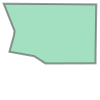

In [10]:
GA.geometry.iloc[0]

In [9]:
GA = GA.to_crs('EPSG:4326')

In [10]:
masterlist3['dropbox_point'] = gpd.points_from_xy(masterlist3.long, masterlist3.lat, crs="EPSG:4326")

In [11]:
masterlist3.head()

,in_2022,in_2021,in_nov_202,lat,long,travel_tim,geometry,dropbox_point
0,1,1,1,31.885024,-85.100646,600.0,"POLYGON ((-85.10582 31.88716, -85.10371 31.887...",POINT (-85.10065 31.88502)
1,1,1,1,31.885024,-85.100646,1200.0,"POLYGON ((-85.10965 31.88447, -85.11018 31.884...",POINT (-85.10065 31.88502)
2,1,1,1,31.885024,-85.100646,1800.0,"POLYGON ((-85.10965 31.88447, -85.11018 31.884...",POINT (-85.10065 31.88502)
3,1,None,1,31.293249,-82.842304,600.0,"POLYGON ((-82.84968 31.29486, -82.85021 31.295...",POINT (-82.84230 31.29325)
4,1,None,1,31.293249,-82.842304,1200.0,"POLYGON ((-82.85249 31.29397, -82.85354 31.294...",POINT (-82.84230 31.29325)


In [12]:
# masterlist3pts = masterlist3.drop('geometry', axis = 1)
masterlist3pts = masterlist3.rename(columns = {'geometry':'isochrone','dropbox_point':'geometry'})

In [13]:
# find out which county each drop box belongs to
masterlist4 = gpd.sjoin(masterlist3pts, GA, how = 'left', op = 'within')
masterlist4 = masterlist4.drop(['STATEFP','COUNTYFP','COUNTYNS','GEOID','NAME','LSAD','ALAND','AWATER'], axis = 1)
masterlist4 = masterlist4.rename(columns = {'geometry':'drop_box_loc'})

In [14]:
# this is in Columbus, county should be 0500000US13215

In [15]:
# and then need to figure out how to join the county with the isochrones.

In [16]:
# dropping the null lat long
masterlist4 = masterlist4[masterlist4.lat != 0].copy()

In [17]:
tofill = masterlist4.index[pd.isna(masterlist4.AFFGEOID) == True].tolist()

In [18]:
tofill

[826, 827, 828]

In [19]:
tofillcol = masterlist4.columns.get_loc('AFFGEOID')

In [20]:
for i in tofill:
    masterlist4.at[i,'AFFGEOID'] = '0500000US13215'

In [21]:
masterlist4[pd.isna(masterlist4.AFFGEOID) == True]

,in_2022,in_2021,in_nov_202,lat,long,travel_tim,isochrone,drop_box_loc,index_right,AFFGEOID


In [22]:
GA1 = GA.rename(columns = {'geometry':'county_boundary'})[['AFFGEOID','county_boundary']].copy()

In [235]:
masterlist5 = pd.merge(masterlist4, GA1, on = 'AFFGEOID', how = 'outer')

In [236]:
masterlist5 = masterlist5.rename(columns = {'isochrone':'geometry'})

In [237]:
clipped_isochrones = gpd.GeoDataFrame()

In [238]:
for i in list(np.arange(0,len(masterlist5))):
    try:
        gdf = gpd.GeoDataFrame(pd.DataFrame(masterlist5.iloc[i]).transpose())
        gdf.crs ='EPSG:4326'
        clipping = gpd.GeoDataFrame([1], geometry=[Polygon(masterlist5.county_boundary.iloc[i])], crs='EPSG:4326') 
        clipped = gpd.clip(gdf,clipping)
        clipped_isochrones = clipped_isochrones.append(clipped)
        print (i)
    except Exception:
        print('error')
        print()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [245]:
clipped_isochrones1 = clipped_isochrones.drop(['drop_box_loc','county_boundary'], axis = 1)

In [247]:
clipped_isochrones1.to_file('20220509_isochrones_clipped_by_county_full_info.shp')

C:\Users\jhuo\AppData\Local\Continuum\anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [248]:
clipped_isochrones1.head()

,in_2022,in_2021,in_nov_202,lat,long,travel_tim,geometry,index_right,AFFGEOID
0,1,1,1,31.885,-85.1006,600,"POLYGON ((-85.10582 31.88716, -85.10371 31.887...",1641,0500000US13239
1,1,1,1,31.885,-85.1006,1200,"POLYGON ((-85.10965 31.88447, -85.11018 31.884...",1641,0500000US13239
2,1,1,1,31.885,-85.1006,1800,"POLYGON ((-85.10965 31.88447, -85.11018 31.884...",1641,0500000US13239
3,1,None,1,31.2932,-82.8423,600,"POLYGON ((-82.84968 31.29486, -82.85021 31.295...",866,0500000US13003
4,1,None,1,31.2932,-82.8423,1200,"POLYGON ((-82.85249 31.29397, -82.85354 31.294...",866,0500000US13003
